# Data Analysis Stage One: Temperature Recognition #

**This part of code are aimed to create a neural net work and find the best weights and biases for the spectrum**

This part is forward data feeding, basically, the spectrum data will be used for training and the target will be the temperature of that spectrum. After training, we hope the net work can give us a decent feature map for distinguish the different temperature spectrum

In [ ]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import Sequential
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Activation, Dense, Flatten
from keras.layers.convolutional import Convolution1D,AveragePooling1D,MaxPooling1D
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims

In [232]:
X=pd.read_table('cube5-300K-30-2s-2V-b-Normalized.dat')['x'].values
X=[item for item in X]
for i in X:
    if i<0.3005 and i>0.2995:
        print(X.index(i))
        break

1133


# Data Import and Index Created#

In [3]:
Val=pd.read_csv('WXProjectWholeData.csv').T
display(Val)
num=3
Tem=[300,600,800]
for k in range(3):
    for j in range(num):
        Tem.insert(j+1,(Tem[j]+Tem[j+1])/2)
for k in range(3):
    for j in range(num):
        Tem.insert(-j-1,(Tem[-j-1]+Tem[-j-2])/2)
print(Tem)
len(Tem)

# Train Test Split for Neural Net Work Training# 
17 Training and 4 Testing

In [7]:
X_train, X_test, y_train, y_test = train_test_split(Val.values, Tem, test_size=0.2, random_state=13)
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape + (1,))
display('The shape for Target:',y_train.shape,'The shape for Feature:',X_train.shape)

'The shape for Target:'

(16, 1)

'The shape for Feature:'

(16, 541)

# Model Built #

In [6]:
from tensorflow.keras import regularizers
model = Sequential()
activation = 'relu'
model.add(Dense(64, input_dim = X_train.shape[1],activation=activation))
model.add(Dense(128, activation=activation))
model.add(Dense(64, activation=activation))
model.add(Dense(64, activation=activation))
model.add(Dense(1, activation=activation))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                34688     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 55,489
Trainable params: 55,489
Non-trainable params: 0
_________________________________________________________________
None


# Training and Best Weights and biases Saved #

In [46]:
checkpoint_name = '3Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]
model.fit(X_train, y_train, epochs=9500, batch_size=550, validation_split = 0.2,validation_data=(X_test, y_test), shuffle = True,callbacks=callbacks_list)

Train on 16 samples, validate on 5 samples
Epoch 1/9500
16/16 [==============================] - 0s 403us/step - loss: 0.6975 - mean_absolute_error: 0.6975 - val_loss: 2.1332 - val_mean_absolute_error: 2.1332

Epoch 00001: val_loss improved from inf to 2.13321, saving model to 3Weights-001--2.13321.hdf5
Epoch 2/9500
16/16 [==============================] - 0s 341us/step - loss: 2.1561 - mean_absolute_error: 2.1561 - val_loss: 2.1352 - val_mean_absolute_error: 2.1352

Epoch 00002: val_loss did not improve from 2.13321
Epoch 3/9500
16/16 [==============================] - 0s 341us/step - loss: 2.1767 - mean_absolute_error: 2.1767 - val_loss: 1.8052 - val_mean_absolute_error: 1.8052

Epoch 00003: val_loss improved from 2.13321 to 1.80524, saving model to 3Weights-003--1.80524.hdf5
Epoch 4/9500
16/16 [==============================] - 0s 371us/step - loss: 0.3519 - mean_absolute_error: 0.3519 - val_loss: 1.5575 - val_mean_absolute_error: 1.5575

Epoch 00004: val_loss improved from 1.80524 

# Weight Load and accuracy Testing #

In [8]:
weights='3Weights-2489--1.32339.hdf5'
model.load_weights(weights)

In [10]:
K=Val.iloc[20:21].values[0]
k=Val.iloc[1:2].values[0]
t=np.array([(K+k)/2])
model.predict(t)

array([[568.41785]], dtype=float32)

In [11]:
X_test[0]
#X = X_test[0].reshape(X_test[0].shape + (1,))
f0=model.predict(t)[0][0]
error0=(f0-568.75)/f0*100
f1=model.predict(X_test)
print('For Weight Loss=1.3 M2')
print('The Predict Tem is:{}K, Actual:{}, Error:{}%'.format("%.2f" % f0,568.75, "%.2f" % error0))
for row in range(f1.shape[0]):
    error=(f1[row][0]-y_test[row])/f1[row][0]*100
    print('The Predict Tem is:{}K, Actual:{}, Error:{}%'.format("%.2f" % f1[row][0],"%.2f" % y_test[row],"%.2f" % error))

For Weight Loss=1.3 M2
The Predict Tem is:568.42K, Actual:568.75, Error:-0.06%
The Predict Tem is:624.65K, Actual:625.00, Error:-0.06%
The Predict Tem is:700.07K, Actual:700.00, Error:0.01%
The Predict Tem is:304.23K, Actual:300.00, Error:1.39%
The Predict Tem is:338.74K, Actual:337.50, Error:0.37%
The Predict Tem is:524.28K, Actual:525.00, Error:-0.14%


Text(0.5, 1.0, 'Accuracy')

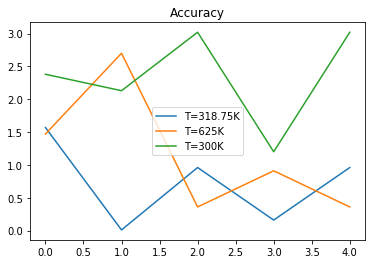

In [309]:
loss=[9.6,8.086,5.529,3.1,1.565]
acc1=[1.57,0.01,0.96,0.16,0.96]
acc2=[1.47,2.7,0.36,0.91,0.36]
acc3=[2.38,2.13,3.02,1.2,3.02]
plt.plot(acc1,label='T=318.75K')
plt.plot(acc2,label='T=625K')
plt.plot(acc3,label='T=300K')
plt.legend()
plt.title('Accuracy')